# Correlated dLight with time-warped PC distances

In [1]:
import toml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from tqdm.auto import tqdm
from rl_analysis.util import zscore
from rl_analysis import ANALYSIS_CONFIG
from sklearn.linear_model import LinearRegression
from rl_analysis.plotting import save_factory, setup_plotting_env, fg

In [2]:
with open(ANALYSIS_CONFIG, 'r') as f:
    config = toml.load(f)

setup_plotting_env()

saver = save_factory(join(config['figures']['dir_wg'], 'ppe-fig'), tight_layout=False)

plt.rcParams['figure.dpi'] = 300

## Loading and setup

In [3]:
# load instead of recompute
out = pd.read_parquet('~/reinforcement_data/processed-dfs/time-warping/performance-prediction-error-distances-and-dopamine.parquet')

In [4]:
out['mouse'].unique()

array(['dls-dlight-1', 'dls-dlight-2', 'dls-dlight-3', 'dls-dlight-4',
       'dls-dlight-5', 'dls-dlight-7', 'dlight-chrimson-1',
       'dlight-chrimson-3', 'dlight-chrimson-5', 'dlight-chrimson-2',
       'dlight-chrimson-4', 'dlight-chrimson-6', 'dlight-chrimson-8',
       'dlight-chrimson-9'], dtype=object)

In [5]:
dist_cols = [c for c in out.columns if 'dist' in c]
log_dist_cols = [f'log_{d}' for d in dist_cols]

out[log_dist_cols] = np.log(out[dist_cols])

/home/wg41/miniconda3/envs/dopamine-paper/lib/python3.9/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/wg41/miniconda3/envs/dopamine-paper/lib/python3.9/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


## Run linear regression on all the output to predict DA

In [6]:
keys = [
    "velocity_2d_mm",
    "acceleration_2d_mm",
    "jerk_2d_mm",
    "velocity_angle",
    "velocity_height",
    "z_dist_from_mean_soft_dtw",
] + ["da"]

In [7]:
# zscore by mouse and syllable
z_mouse_syllable = []
for mouse, mouse_df in out.groupby(['mouse', 'uuid', 'syllable'], sort=False):
    mouse_df = mouse_df.copy()
    mouse_df[keys] = zscore(mouse_df[keys])
    z_mouse_syllable.append(mouse_df)
z_mouse_syllable = pd.concat(z_mouse_syllable)
z_mouse_syllable = z_mouse_syllable.dropna(subset=keys)
avg_vals = z_mouse_syllable.groupby(['mouse', 'uuid', 'syllable']).mean()

In [8]:
n_boots = 1_000
coefs = []
for i in tqdm(range(n_boots)):
    sample = avg_vals.sample(frac=1, replace=True)
    sample[keys] = zscore(sample[keys])
    sample = sample.dropna(subset=keys)
    mdl = LinearRegression()

    mdl.fit(sample[keys[:-1]], sample[keys[-1:]])
    coefs.append(mdl.coef_[0])
coefs = np.array(coefs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
mdl.score(sample[keys[:-1]], sample[keys[-1:]])

0.00595361083475876

In [10]:
np.quantile(coefs, [0.025, 0.975], axis=0)

array([[-0.05142287, -0.01883468, -0.00912761, -0.0021477 , -0.02389292,
        -0.02117742],
       [-0.00728016,  0.10086687,  0.01919214,  0.0248782 ,  0.03125423,
         0.03339123]])

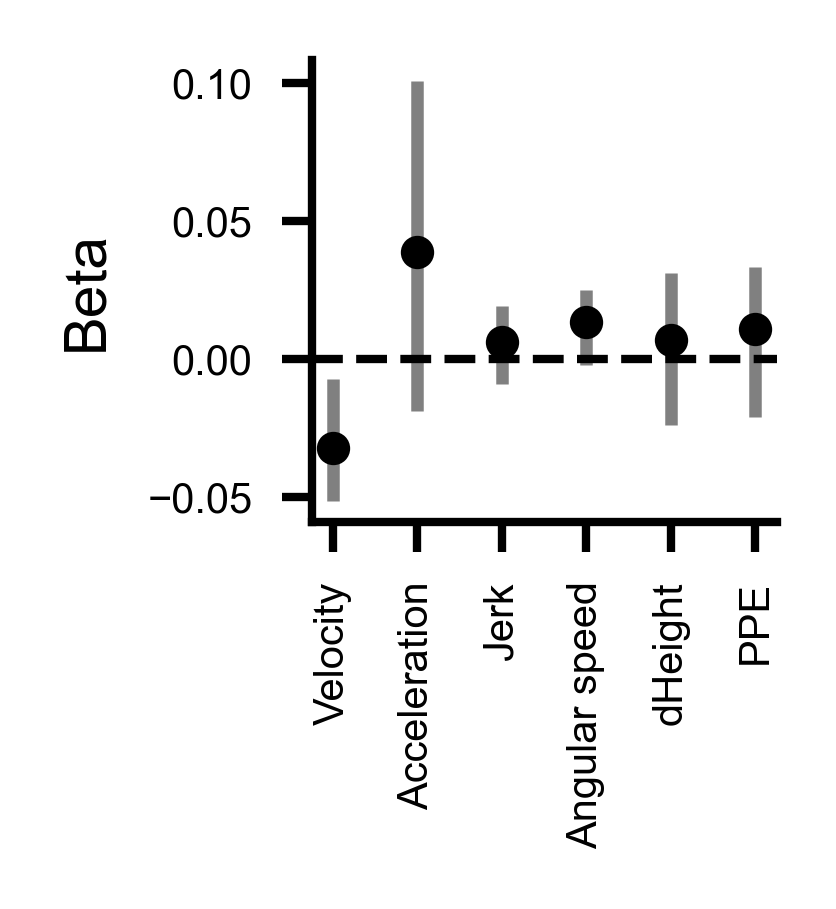

In [11]:
mu = np.mean(coefs, axis=0)
fig = fg(1, 1)
fig.dpi = 300
ax = fig.gca()
ax.errorbar(
    range(coefs.shape[1]),
    mu,
    yerr=[mu - np.quantile(coefs, 0.025, axis=0), np.quantile(coefs, 0.975, axis=0) - mu],
    fmt="o",
    markeredgewidth=0,
    markersize=4,
    elinewidth=1.5,
    ecolor="gray",
    color="k",
)
ax.axhline(0, color="k", ls="--", lw=1)
ax.set(
    xticks=range(len(mu)),
    xticklabels=["Velocity", "Acceleration", "Jerk", "Angular speed", "dHeight", "PPE"],
    ylabel="Beta",
)
plt.xticks(rotation=90)
sns.despine()
saver(fig, 'ppe-linear-regression');